In [1]:
import pandas as pd
from scipy.spatial.distance import cosine
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import umap
from adjustText import adjust_text
import re
from scipy.special import softmax
from collections import Counter
from sklearn.cluster import KMeans


In [3]:
# embeddings = open('../../data/all_glove_gensim_word2vec.txt').readlines()

In [4]:
# embeddings = [line.strip() for line in embeddings]

In [5]:
# embedding_dict = {}
# for line in embeddings[1:]:
#     line = line.split()
#     embedding_dict[line[0]] = [float(item) for item in line[1:]]


In [6]:
# pickle.dump(embedding_dict, open('embedding_dict.p', 'wb'))

In [7]:
# embedding_dict = pickle.load(open('embedding_dict.p', 'rb'))

In [8]:
# df_srl_dem = pd.read_csv('srl_dem.tsv', sep='\t')

In [9]:
# df_srl_rep = pd.read_csv('srl_rep.tsv', sep='\t')

In [10]:
# len(df_srl_rep)

In [11]:
# df_srl_emb = df_srl_emb.sample(100000)

In [12]:
def get_args_df(df):   
    args_list_all = []
    for idx, row in df.iterrows():
        annotation = eval(row['Verb_annotation'])
        # extract verb and its embedding
        verb = annotation['verb'].lower()
        text = [t.lower() for t in eval(row['Text'])]
        verb_idx = text.index(verb)
        verb_emb = embedding_dict.get(verb, 0)

        # extract arg0
        arg0_idx = [idx for (idx, tag) in enumerate(annotation['tags']) if 'ARG0' in tag]
        # if arg0 is too long, may bring trouble
        arg0_emb = []
        if len(arg0_idx) > 0 and len(arg0_idx) <= 3:
            for idx in arg0_idx:
                emb = embedding_dict.get(text[idx], 0) 
                if emb != 0 and len(emb) == 300:
                    arg0_emb.append(emb)
            arg0_emb = np.asarray(arg0_emb)
            if arg0_emb.shape[0] > 1:
                # take the sum of word embeddings
                arg0_emb = np.sum(arg0_emb, axis=0)
                arg0_emb = np.expand_dims(arg0_emb, axis=0)
            try:
                arg0_emb = softmax(arg0_emb)
            except:
                pass
            arg0_tok = [text[idx] for idx in arg0_idx]
            arg0_tok = ' '.join([item for item in arg0_tok])

        else:
            arg0 = 'No_arg0'
            arg0_idx = -1
            arg0_emb = -1
            arg0_tok = 'No_arg0'

        arg1_idx = [idx for (idx, tag) in enumerate(annotation['tags']) if 'ARG1' in tag]
        arg1_emb = []
        if len(arg1_idx) > 0  and len(arg1_idx) <= 3:
            for idx in arg1_idx:
                emb = embedding_dict.get(text[idx], 0)
                if emb != 0 and len(emb) == 300:
                    arg1_emb.append(emb)
            arg1_emb = np.asarray(arg1_emb)
            if arg1_emb.shape[0] > 1:
                arg1_emb = np.sum(arg1_emb, axis=0)
                arg1_emb = np.expand_dims(arg1_emb, axis=0)
            try:
                arg1_emb = softmax(arg1_emb)
            except:
                pass

            arg1_tok = [text[idx] for idx in arg1_idx]
            arg1_tok = ' '.join([item for item in arg1_tok])


        else:
            arg1 = 'No_arg1'
            arg1_idx = -1
            arg1_emb = -1
            arg1_tok = 'No_arg1'
        if arg0_idx != -1 or arg1_idx != -1:
            args_list_all.append([verb, verb_idx, verb_emb, arg0_tok, arg0_idx, arg0_emb, arg1_tok, \
                                  arg1_idx, arg1_emb])
    return pd.DataFrame(args_list_all, columns=['Verb', 'Verb_idx', 'Verb_emb', 'Arg0_tok', 'Arg0_idx',\
                                               'Arg0_emb', 'Arg1_tok', 'Arg1_idx', 'Arg1_emb'])

In [13]:
# df_args_rep = get_args_df(df_srl_rep)
# pickle.dump(df_args_rep, open('rep_srl_parsed.p', 'wb'))

In [14]:
# df_args_dem = get_args_df(df_srl_dem)
# pickle.dump(df_args_dem, open('dem_srl_parsed.p', 'wb'))

In [15]:
df_args_dem = pickle.load(open('dem_srl_parsed.p', 'rb'))

In [16]:
df_args_rep = pickle.load(open('rep_srl_parsed.p', 'rb'))

In [17]:
len(df_args_rep)

358118

In [18]:
len(df_args_dem)

1342760

In [19]:
for col in ['Verb', 'Arg0_tok', 'Arg1_tok']:
    df_args_rep[col] = df_args_rep[col].apply(lambda x: str(x).encode('utf-8', 'replace').decode('utf-8'))

In [20]:
for col in ['Verb', 'Arg0_tok', 'Arg1_tok']:
    df_args_dem[col] = df_args_dem[col].apply(lambda x: str(x).encode('utf-8', 'replace').decode('utf-8'))

In [21]:
df_args_rep.head(2)

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb
0,is,4,"[-0.13593, 0.226247, -0.155218, 0.263514, 0.45...",No_arg0,-1,-1,the beauty that,"[1, 2, 3]","[[0.0019967582248604223, 0.0030668990752737374..."
1,tasked,33,"[0.095075, -0.361468, -0.10605, -0.078711, -0....",No_arg0,-1,-1,dnc fbi,"[31, 32]","[[0.007765591530827481, 0.0033374519706759163,..."


# triplet embeddings

In [22]:
df_args_dem = df_args_dem[(df_args_dem['Arg0_idx'] != -1 ) & (df_args_dem['Arg1_idx'] != -1)]

In [23]:
df_args_rep = df_args_rep[(df_args_rep['Arg0_idx'] != -1 ) & (df_args_rep['Arg1_idx'] != -1)]

In [24]:
df_args_dem = df_args_dem[[item.shape[0] == 1 for item in df_args_dem['Arg0_emb']]]

In [25]:
df_args_dem = df_args_dem[[item.shape[0] == 1 for item in df_args_dem['Arg1_emb']]]

In [26]:
df_args_dem['Arg0_emb'] = df_args_dem['Arg0_emb'].apply(lambda x: x[0])
df_args_dem['Arg1_emb'] = df_args_dem['Arg1_emb'].apply(lambda x: x[0])

In [27]:
df_args_dem.head(2)

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb
9,stop,7,"[-0.007348, 0.252662, -0.390302, 0.288428, 0.3...",ri 's @agneronha,"[0, 1, 2]","[0.004248574408256272, 0.002491384283911343, 0...",scammers,[8],"[0.0019371563946450092, 0.0018215214653238335,..."
10,see,2,"[0.072356, 0.057338, -0.518452, 0.106316, -0.0...",you,[1],"[0.0016557294507455345, 0.004215265873760498, ...",a # covid19scam,"[3, 4, 5]","[0.002044991644585729, 0.001557993388268218, 0..."


In [28]:
df_args_dem =df_args_dem[df_args_dem['Verb_emb']!=0]

In [29]:
def concat_emb(row):
    try:
        triplet_emb = np.concatenate([row['Arg0_emb'], np.asarray(row['Verb_emb']), row['Arg1_emb']])
    except:
        print(row['Arg0_emb'])
        print(row['Verb_emb'])
        print(row['Arg1_emb'])
    return triplet_emb

In [30]:
df_args_dem['triplet_emb'] = df_args_dem.apply(lambda row: concat_emb(row), axis=1)

In [31]:
df_args_dem.head().apply(lambda x: np.asarray(x['triplet_emb']).shape, axis=1)

9     (900,)
10    (900,)
22    (900,)
31    (900,)
34    (900,)
dtype: object

In [32]:
df_args_dem['triplet'] = df_args_dem['Arg0_tok'] + ' ' + df_args_dem['Verb'] + ' ' + df_args_dem['Arg1_tok']

In [33]:
df_args_dem.head(2)

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb,triplet_emb,triplet
9,stop,7,"[-0.007348, 0.252662, -0.390302, 0.288428, 0.3...",ri 's @agneronha,"[0, 1, 2]","[0.004248574408256272, 0.002491384283911343, 0...",scammers,[8],"[0.0019371563946450092, 0.0018215214653238335,...","[0.004248574408256272, 0.002491384283911343, 0...",ri 's @agneronha stop scammers
10,see,2,"[0.072356, 0.057338, -0.518452, 0.106316, -0.0...",you,[1],"[0.0016557294507455345, 0.004215265873760498, ...",a # covid19scam,"[3, 4, 5]","[0.002044991644585729, 0.001557993388268218, 0...","[0.0016557294507455345, 0.004215265873760498, ...",you see a # covid19scam


In [34]:
len(df_args_dem)

303997

In [35]:
def reduce_dim_cluster(df):
    umap_reduc = umap.UMAP(min_dist=0.0,n_neighbors=5)\
            .fit_transform(np.array(df['triplet_emb'].tolist()).squeeze())
    df['umap_emb_x'] = umap_reduc[:,0]
    df['umap_emb_y'] = umap_reduc[:,1]
    kmeans = KMeans(n_clusters=5, random_state=0).fit(umap_reduc)
    df['cluster'] = kmeans.labels_
    return df

In [36]:
df_args_dem_reduc = reduce_dim_cluster(df_args_dem.head(200))

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [37]:
df_args_dem_reduc.head(2)

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb,triplet_emb,triplet,umap_emb_x,umap_emb_y,cluster
9,stop,7,"[-0.007348, 0.252662, -0.390302, 0.288428, 0.3...",ri 's @agneronha,"[0, 1, 2]","[0.004248574408256272, 0.002491384283911343, 0...",scammers,[8],"[0.0019371563946450092, 0.0018215214653238335,...","[0.004248574408256272, 0.002491384283911343, 0...",ri 's @agneronha stop scammers,10.268622,0.263776,0
10,see,2,"[0.072356, 0.057338, -0.518452, 0.106316, -0.0...",you,[1],"[0.0016557294507455345, 0.004215265873760498, ...",a # covid19scam,"[3, 4, 5]","[0.002044991644585729, 0.001557993388268218, 0...","[0.0016557294507455345, 0.004215265873760498, ...",you see a # covid19scam,12.089372,-0.341708,0


20

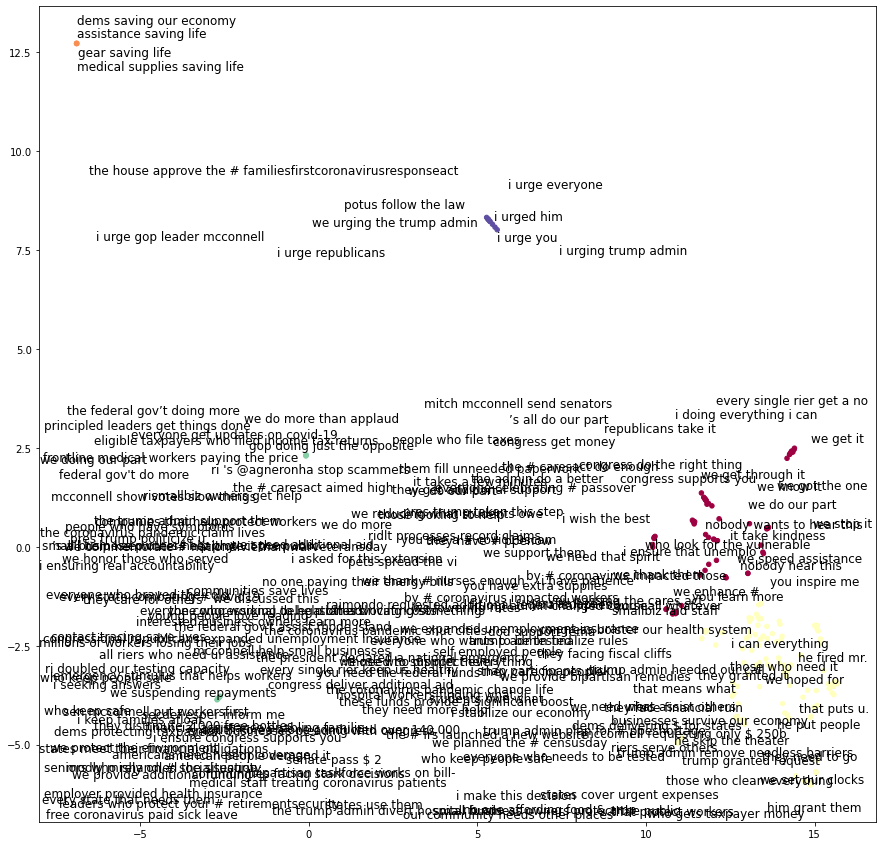

In [38]:
x = df_args_dem_reduc['umap_emb_x'].tolist()
y = df_args_dem_reduc['umap_emb_y'].tolist()
l = df_args_dem_reduc['cluster'].tolist()
text = df_args_dem_reduc['triplet'].tolist()
plt.figure(figsize=(15, 15))
plt.scatter(x,y, s=20, c=l, cmap='Spectral')
texts = [plt.text(x[idx], y[idx], text[idx], fontsize=12) for idx in range(len(text))]
adjust_text(texts, expand_text=(1.02, 1.02), force_text=(0.75, 0.75), lim=20)
# plt.title('Rep verbs')
# plt.savefig('rep_verbs.png', format='png')

In [34]:
len(df_args_dem)

304672

In [35]:
df_args_dem.head(2)

,Verb,Verb_idx,Verb_emb,Arg0_tok,Arg0_idx,Arg0_emb,Arg1_tok,Arg1_idx,Arg1_emb,triplet_emb,triplet
9,stop,7,"[-0.007348, 0.252662, -0.390302, 0.288428, 0.3...",ri 's @agneronha,"[0, 1, 2]","[0.004248574408256272, 0.002491384283911343, 0...",scammers,[8],"[0.0019371563946450092, 0.0018215214653238335,...","[-0.001162269197098719, 0.25697490574923515, -...",ri 's @agneronha stop scammers
10,see,2,"[0.072356, 0.057338, -0.518452, 0.106316, -0.0...",you,[1],"[0.0016557294507455345, 0.004215265873760498, ...",a # covid19scam,"[3, 4, 5]","[0.002044991644585729, 0.001557993388268218, 0...","[0.07605672109533126, 0.06311125926202872, -0....",you see a # covid19scam


In [37]:
df_args_dem.columns.values

array(['Verb', 'Verb_idx', 'Verb_emb', 'Arg0_tok', 'Arg0_idx', 'Arg0_emb',
       'Arg1_tok', 'Arg1_idx', 'Arg1_emb', 'triplet_emb', 'triplet'],
      dtype=object)

In [38]:
df_args_dem = df_args_dem[['Verb', 'Verb_emb', 'Arg0_tok', 'Arg0_emb',
       'Arg1_tok', 'Arg1_emb', 'triplet_emb', 'triplet']]

In [41]:
df_args_dem = df_args_dem.drop_duplicates(subset=['triplet'])

In [42]:
len(df_args_dem)

133309

In [39]:
df_args_dem_sample = df_args_dem.sample(10000).reset_index()

In [40]:
umap_dem = umap.UMAP(min_dist=0.0,n_neighbors=5)\
            .fit(np.array(df_args_dem_sample['triplet_emb'].tolist()).squeeze())

In [46]:
import umap.plot

In [42]:
# umap.plot.output_notebook()

In [47]:
from bokeh.plotting import output_notebook

In [48]:
output_notebook()

Loading BokehJS ...

In [49]:
p = umap.plot.interactive(umap_dem, hover_data=df_args_dem_sample[['triplet']], point_size=5)

In [50]:
umap.plot.show(p)